In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import seaborn as sns
from adabmDCA.fasta import get_tokens, encode_sequence

In [2]:
def get_test_data(dataset, folder_id, num_train_seqs, prob_th=0.8):
    base_path = f"../experiments/datasets/{dataset}/{folder_id}"
    
    # True labels
    data = {}
    df_true = pd.read_csv(os.path.join(base_path, f"test.csv"))
    data_true = {
        "header": np.array(df_true["header"].values),
        "label": np.array(df_true["label"].values),
        "sequence": np.array(df_true["sequence_align"].values),
    }
    
    # header to sequence mapping
    header_to_seq = {header: seq for header, seq in zip(data_true["header"], data_true["sequence"])}
    
    unique_labels = np.unique(data_true["label"])
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    # Inferred labels
    for method in ["msa", "rbm", f"embedding_foundation", f"embedding_contrastive"]:
        data_method = np.load(os.path.join(base_path, f"test.{method}_{num_train_seqs}.npz"), allow_pickle=True)
        sequences_method, labels_method, headers_method, prob_method = [], [], [], []
        for h, l, p in zip(data_method["headers"], data_method["labels"], data_method["probs"]):
            if h in header_to_seq:
                if p[label_to_idx[l]] >= prob_th:
                    sequences_method.append(header_to_seq[h])
                    labels_method.append(l)
                    headers_method.append(h)
                    prob_method.append(p[label_to_idx[l]])
            else:
                print(f"Warning: Header {h} not found in true data.")
        df_method = pd.DataFrame({
            "header": headers_method,
            "label": labels_method,
            "sequence": sequences_method,
            "prob": prob_method
        })
        data[method.split("_")[-1]] = df_method
    
    return data_true, data

def get_train_sequences(dataset, folder_id, num_train_seqs, tokens):
    # import training sequences
    fname_train = f"../experiments/datasets/{dataset}/{folder_id}/train_{num_train_seqs}.csv"
    train_seqs = pd.read_csv(fname_train)["sequence_align"].values
    train_seqs = encode_sequence(train_seqs, tokens)
    
    return train_seqs

In [3]:
dataset = "RR"
folder_id = "t10.4_t20.7"
num_train_seqs = 100

In [4]:
tokens = get_tokens("protein")
prob_th = 0.8
data_test, data_test_pred = get_test_data(dataset, folder_id, num_train_seqs, prob_th=prob_th)
data_train = get_train_sequences(dataset, folder_id, num_train_seqs, tokens)

In [5]:
def get_seqid_from_train(s, train_seqs):
    # get distance from training sequences
    L = len(s)
    seqid = (s == train_seqs).sum(1) / L
    return np.max(seqid)

def get_fp_seqid_with_train(data_test, data_test_pred, train_sequences, models_key=["msa", "contrastive"]):
    seq_ids_dict = {k: [] for k in models_key}
    for k in models_key:
        print(f"Processing model: {k}")
        enc_seqs = encode_sequence(data_test_pred[k]["sequence"].values, tokens)
        # only select wrong predictions
        header_to_label = {header: lab for header, lab in zip(data_test["header"], data_test["label"])}
        header_to_seq = {header: seq for header, seq in zip(data_test["header"], data_test["sequence"])}
        # get wrong predictions
        labels_true = np.array([header_to_label[h] for h in data_test_pred[k]["header"]])
        wrong_preds_mask = data_test_pred[k]["label"] != labels_true
        
        for s in enc_seqs[wrong_preds_mask]:
            seq_id = get_seqid_from_train(s, train_sequences)
            seq_ids_dict[k].append(seq_id)
    return seq_ids_dict

In [7]:
seq_ids_dict = get_fp_seqid_with_train(data_test, data_test_pred, data_train, models_key=["msa", "foundation"])

Processing model: msa
Processing model: foundation


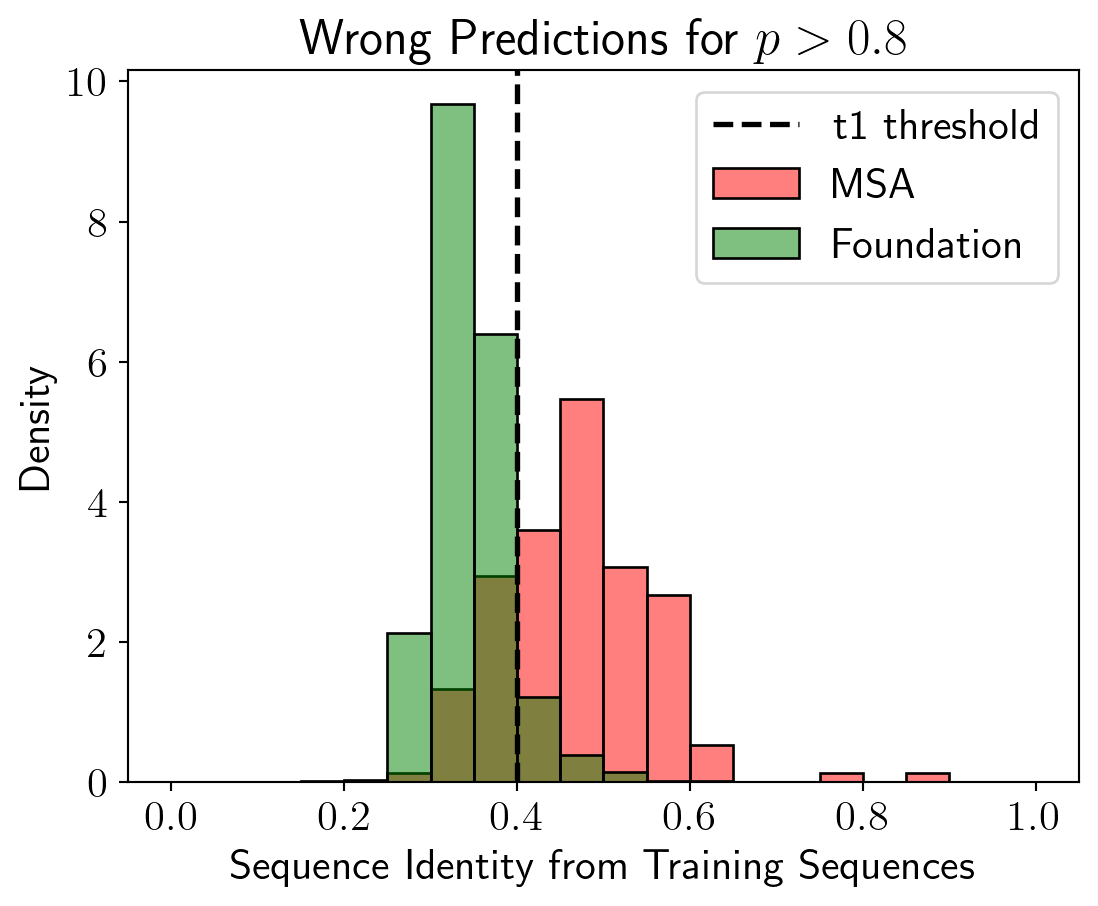

In [8]:
# use latex
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(6, 5), dpi=192)
model_compare = "Foundation"

sns.histplot(seq_ids_dict["msa"], bins=20, stat="density", label="MSA", color='red', alpha=0.5, edgecolor='black', binrange=(0, 1), binwidth=0.05)
sns.histplot(seq_ids_dict[model_compare.lower()], bins=20, stat="density", label=model_compare, color='green', alpha=0.5, edgecolor='black', binrange=(0, 1), binwidth=0.05)
plt.axvline(0.4, color='black', linestyle='--', label='t1 threshold', linewidth=2)
plt.xlabel("Sequence Identity from Training Sequences")
plt.ylabel("Density")
plt.title(r"Wrong Predictions for $p>0.8$")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

Analysis of all sequences with train/test SeqID > 0.4

In [9]:
data_test, data_test_pred = get_test_data(dataset, folder_id, num_train_seqs, prob_th=0.0)
data_train = get_train_sequences(dataset, folder_id, num_train_seqs, tokens)

In [10]:
def get_fp_seqid_with_train_2(data_test, data_test_pred, train_sequences, models_key=["msa", "contrastive"]):
    seq_ids_dict = {k: [] for k in models_key}
    wrong_masks = {k: [] for k in models_key}
    for k in models_key:
        print(f"Processing model: {k}")
        enc_seqs = encode_sequence(data_test_pred[k]["sequence"].values, tokens)
        # only select wrong predictions
        header_to_label = {header: lab for header, lab in zip(data_test["header"], data_test["label"])}
        # get wrong predictions
        labels_true = np.array([header_to_label[h] for h in data_test_pred[k]["header"]])
        wrong_preds_mask = data_test_pred[k]["label"] != labels_true
        wrong_masks[k] = wrong_preds_mask
        
        for s in enc_seqs:
            seq_id = get_seqid_from_train(s, train_sequences)
            seq_ids_dict[k].append(seq_id)
    return seq_ids_dict, wrong_masks

In [11]:
# compute list of distances from the training sequence
seq_ids_dict, wrong_masks = get_fp_seqid_with_train_2(data_test, data_test_pred, data_train, models_key=["msa", "foundation", "contrastive"])
# add column to the dataframe
for k in seq_ids_dict.keys():
    data_test_pred[k]["seq_id_train"] = seq_ids_dict[k]
    data_test_pred[k]["is_correct"] = ~wrong_masks[k]

Processing model: msa


Processing model: foundation
Processing model: contrastive


In [12]:
# compute pearson correlation
def compute_pearson_correlation(data, x_col, y_col):
    corr = data[[x_col, y_col]].corr(method='pearson')
    return corr.iloc[0, 1]
# compute pearson correlation for msa
pearson_corr_msa = compute_pearson_correlation(data_test_pred["msa"], "seq_id_train", "prob")
print(f"Pearson correlation for MSA: {pearson_corr_msa:.2f}")
# compute pearson correlation for foundation
pearson_corr_foundation = compute_pearson_correlation(data_test_pred["foundation"], "seq_id_train", "prob")
print(f"Pearson correlation for Foundation: {pearson_corr_foundation:.2f}")
# compute pearson correlation for contrastive
pearson_corr_contrastive = compute_pearson_correlation(data_test_pred["contrastive"], "seq_id_train", "prob")
print(f"Pearson correlation for contrastive: {pearson_corr_contrastive:.2f}")

# do the same pearson calculation, but only for sequences with seq_id_train > 0.4
pearson_corr_msa_high = compute_pearson_correlation(data_test_pred["msa"][data_test_pred["msa"]["seq_id_train"] > 0.4], "seq_id_train", "prob")
print(f"Pearson correlation for MSA (seq_id_train > 0.4): {pearson_corr_msa_high:.2f}")
pearson_corr_foundation_high = compute_pearson_correlation(data_test_pred["foundation"][data_test_pred["foundation"]["seq_id_train"] > 0.4], "seq_id_train", "prob")
print(f"Pearson correlation for Foundation (seq_id_train > 0.4): {pearson_corr_foundation_high:.2f}")
# compute pearson correlation for contrastive (seq_id_train > 0.4)
pearson_corr_contrastive_high = compute_pearson_correlation(data_test_pred["contrastive"][data_test_pred["contrastive"]["seq_id_train"] > 0.4], "seq_id_train", "prob")
print(f"Pearson correlation for Contrastive (seq_id_train > 0.4): {pearson_corr_contrastive_high:.2f}")

Pearson correlation for MSA: 0.28
Pearson correlation for Foundation: -0.02
Pearson correlation for contrastive: -0.00
Pearson correlation for MSA (seq_id_train > 0.4): 0.55
Pearson correlation for Foundation (seq_id_train > 0.4): -0.17
Pearson correlation for Contrastive (seq_id_train > 0.4): -0.13


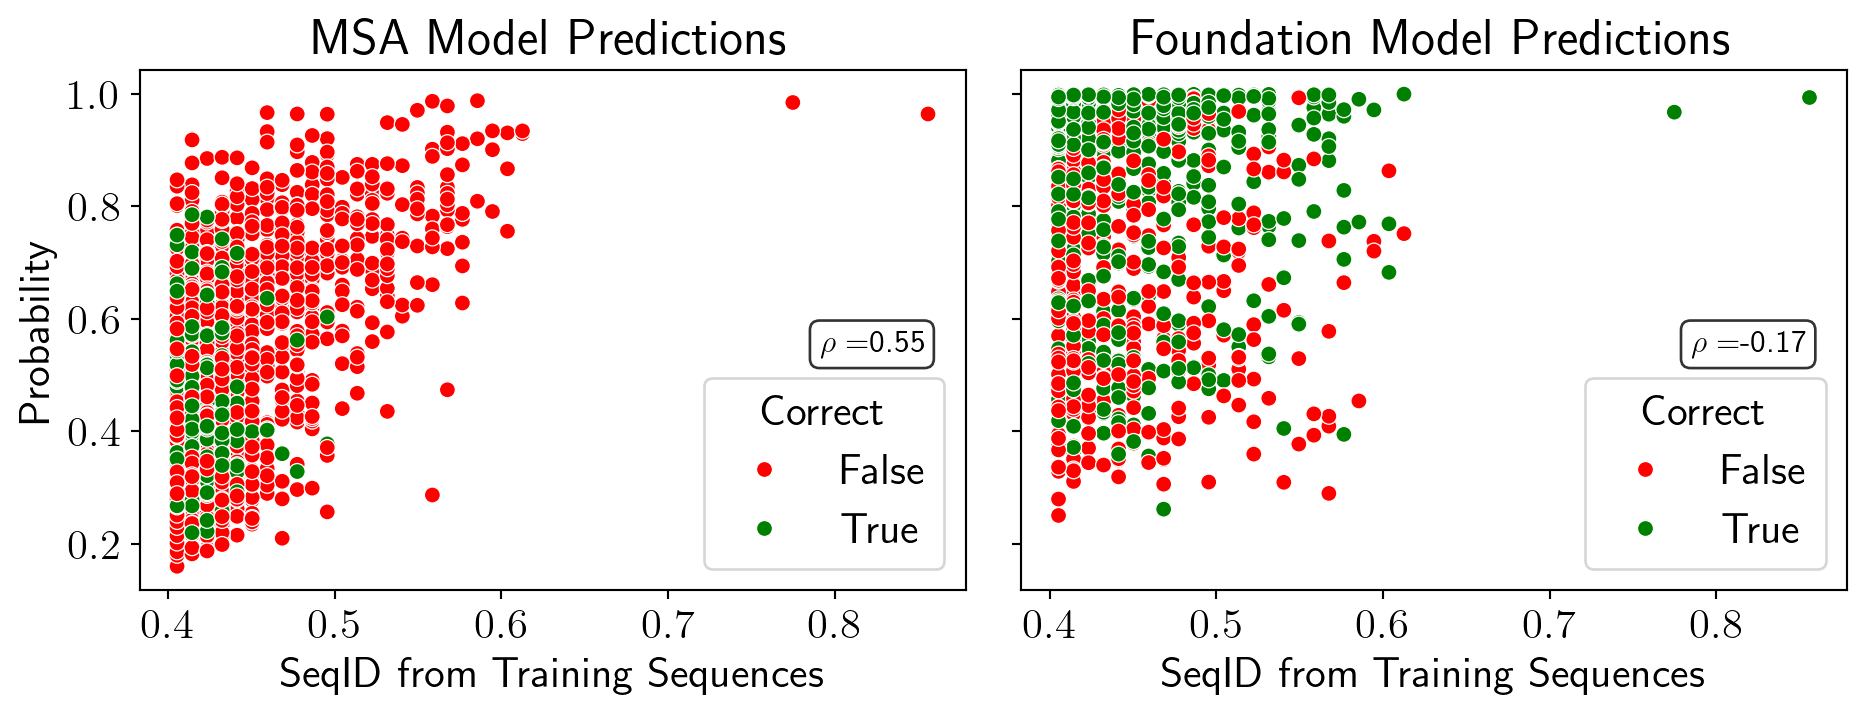

In [13]:
# make a 1 row 2 columns plot with the two scatter plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=192, sharey=True)
sns.scatterplot(
    data=data_test_pred["msa"][data_test_pred["msa"]["seq_id_train"] > 0.4],
    x="seq_id_train",
    y="prob",
    hue="is_correct",
    palette={True: "green", False: "red"},
    ax=axes[0]
)
axes[0].legend(title="Correct", loc="lower right")
axes[0].set_xlabel("SeqID from Training Sequences")
axes[0].set_ylabel("Probability")
axes[0].set_title("MSA Model Predictions")
axes[0].annotate(r"$\rho = $" + f"{pearson_corr_msa_high:.2f}",
                 xy=(0.95, 0.5), xycoords='axes fraction',
                 fontsize=12, ha='right', va='top',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
sns.scatterplot(
    data=data_test_pred["foundation"][data_test_pred["foundation"]["seq_id_train"] > 0.4],
    x="seq_id_train",
    y="prob",
    hue="is_correct",
    palette={True: "green", False: "red"},
    ax=axes[1]
)
axes[1].legend(title="Correct", loc="lower right")
axes[1].set_xlabel("SeqID from Training Sequences")
axes[1].set_title("Foundation Model Predictions")
axes[1].annotate(r"$\rho = $" + f"{pearson_corr_foundation_high:.2f}",
                 xy=(0.95, 0.5), xycoords='axes fraction',
                 fontsize=12, ha='right', va='top',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.tight_layout()